Using a variational autoencoder to generate images conditioned on flower labels
]

In [ ]:
# Use dataset from Kaggle
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("rahmasleam/flowers-dataset")
path = os.path.join(path, "flower_photos")

In [ ]:
# Use local dataset
path = "flower_photos"

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

transform = transforms.Compose([ # data augmentations
    transforms.Resize(128),
    transforms.RandomCrop(128),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(path, transform=transform)

size = len(dataset)
train_size = int(0.85*size)
test_size = int(0.05*size)
val_size = size - train_size - test_size

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(test_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
num_classes = len(dataset.classes)
dataset.classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [52]:
flower_dict = {"daisy": 0, "dandelion": 1, "roses": 2, "sunflowers": 3, "tulips": 4}

In [12]:
class Autoencoder128(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        # ---------- Encoder ----------
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),   # 3x128x128 -> 32x64x64
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 64x32x32
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 128x16x16
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),# 256x8x8
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1), # 512x4x4
            nn.Flatten(),
            nn.Linear(512*4*4, latent_dim)  # latent vector
        )

        # ---------- Decoder ----------
        self.fc2 = nn.Linear(latent_dim, 512*4*4)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512*4*4),
            nn.Unflatten(1, (512, 4, 4)),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), # 8x8
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   # 64x64
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),    # 128x128
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


In [13]:
class CVAE(Autoencoder128):
    def __init__(self, latent_dim, num_classes):
        super().__init__(latent_dim = latent_dim)
        # Add mu and log_var layers for reparameterization
        self.mu = nn.Linear(self.latent_dim, self.latent_dim)
        self.log_var = nn.Linear(self.latent_dim, self.latent_dim)

        self.label_projector = nn.Sequential(
            nn.Linear(num_classes, self.latent_dim),
            nn.ReLU(),
        )
    def condition_on_label(self, z, y):
        #projected_label = self.label_projector(y.float())
        return z #+ projected_label

    def reparameterize(self, mu, log_var):
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * log_var)
        # Generate random noise using the same shape as std
        eps = torch.randn_like(std)
        # Return the reparameterized sample
        return mu + eps * std

    def forward(self, x, y):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        # Pass the latent variable through the decoder
        decoded = self.decoder(self.condition_on_label(z, y))
        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var

    def sample(self, num_samples, y):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.latent_dim).to(device)
            # Pass the noise through the decoder to generate samples
            samples = self.decoder(self.condition_on_label(z, y))
        # Return the generated samples
        return samples


In [23]:
def train_cvae(loader, val_loader, latent_dim=256, epochs=100, lr=1e-3, KLD_weight=3):

  model = CVAE(latent_dim=latent_dim, num_classes=num_classes).to(device)

  criterion = nn.MSELoss(reduction="sum")
  optimizer = optim.Adam(model.parameters(), lr=lr)

  losses = []
  val_losses = []
  min_val_loss = None

  for epoch in range(epochs):
    total_loss = 0.0
    model.train()
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        labels = F.one_hot(labels, num_classes=num_classes)

        # Forward pass
        encoded, decoded, mu, log_var = model(imgs, labels)

        # Compute the loss and perform backpropagation
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = criterion(decoded, imgs) + KLD_weight * KLD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the running loss
        total_loss += loss.item() * imgs.size(0)

    epoch_loss = total_loss / len(loader.dataset)
    val_loss = eval_model(model, val_loader)

    losses.append(epoch_loss)
    val_losses.append(val_loss)

    if min_val_loss is None:
      min_val_loss = val_loss

    if epoch % 5 == 0:
      min_val_loss = min(val_loss, min_val_loss)
      if val_loss <= min_val_loss:
        torch.save(model.state_dict(), "CVAE512_bestmodel.pth")

    print(f"Epoch {epoch+1}/{epochs} | Loss = {epoch_loss:.4f} | Validation Loss = {val_loss:.4f}")

  return model, losses, val_losses

In [101]:
def eval_model(model, loader, KLD_weight=3, training=True):
  model.eval()
  total_loss = 0.0
  criterion = nn.MSELoss(reduction="sum")

  originals = []
  mus = []
  reconstructions = []

  with torch.no_grad():
      for imgs, labels in loader:
          imgs = imgs.to(device)
          labels = labels.to(device)
          labels = F.one_hot(labels, num_classes=num_classes)

          encoded, decoded, mu, log_var = model(imgs, labels)
          KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
          loss = criterion(decoded, imgs) + KLD_weight * KLD

          if not training:
            mus.append(mu.cpu())
            originals.append(imgs.cpu())
            reconstructions.append(decoded.cpu())

          # Update the running loss
          total_loss += loss.item() * imgs.size(0)

  if not training:
    mus = torch.cat(mus)
    originals = torch.cat(originals)
    reconstructions = torch.cat(reconstructions)

    mse = F.mse_loss(reconstructions, originals)
    return mse, (originals, mus, reconstructions)

  return total_loss / len(loader.dataset)

In [24]:
model, losses, val_losses = train_cvae(train_loader, val_loader, latent_dim=512)

Epoch 1/100 | Loss = 104576.8311 | Validation Loss = 86374.3571
Epoch 2/100 | Loss = 88124.4810 | Validation Loss = 82645.0343
Epoch 3/100 | Loss = 77817.7517 | Validation Loss = 71386.8049
Epoch 4/100 | Loss = 71616.2045 | Validation Loss = 69225.4681
Epoch 5/100 | Loss = 67070.1845 | Validation Loss = 62419.2654
Epoch 6/100 | Loss = 64560.8712 | Validation Loss = 61604.3101
Epoch 7/100 | Loss = 63384.9615 | Validation Loss = 59629.1877
Epoch 8/100 | Loss = 61474.2071 | Validation Loss = 57470.2626
Epoch 9/100 | Loss = 60762.5720 | Validation Loss = 58390.4090
Epoch 10/100 | Loss = 59823.8762 | Validation Loss = 57646.5095
Epoch 11/100 | Loss = 59451.0263 | Validation Loss = 56723.1367
Epoch 12/100 | Loss = 59180.9135 | Validation Loss = 57348.2991
Epoch 13/100 | Loss = 58493.7840 | Validation Loss = 54948.6516
Epoch 14/100 | Loss = 57283.5560 | Validation Loss = 54856.6093
Epoch 15/100 | Loss = 56394.8399 | Validation Loss = 53998.5286
Epoch 16/100 | Loss = 55370.6785 | Validation Lo

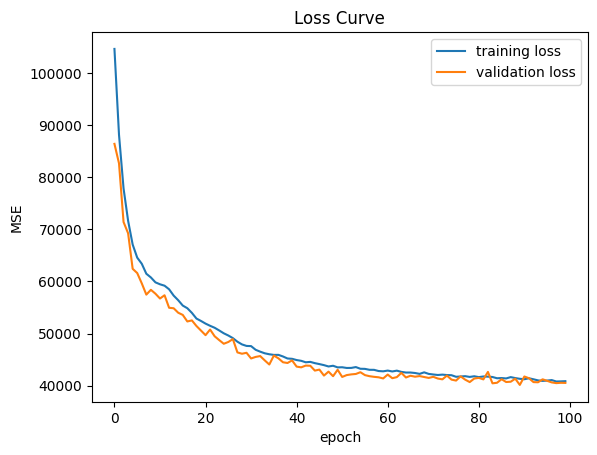

In [88]:
plt.plot(np.arange(len(losses)), losses, label="training loss")
plt.plot(np.arange(len(losses)), val_losses, label="validation loss")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.title("Loss Curve")
plt.legend()

In [47]:
path = "CVAE512_100epochs.pth"
torch.save(model.state_dict(), path)

In [102]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def batch_ssim(originals, reconstructions):
    originals = originals.permute(0,2,3,1).cpu().numpy()  # N,H,W,3
    reconstructions = reconstructions.permute(0,2,3,1).cpu().numpy()
    ssims = []
    for a,b in zip(originals, reconstructions):
        # skimage expects float images in [0,1] (or 0-255) and multichannel=True
        score = ssim(a, b, data_range=1.0, multichannel=True, channel_axis=-1)
        ssims.append(score)
    return np.array(ssims)

In [103]:
mse, v = eval_model(model, test_loader, training=False)
print(f"Test MSE: {mse} | Test SSIM: {batch_ssim(v[0], v[2]).mean()} ")

Test MSE: 0.022373894229531288 | Test SSIM: 0.3359217941761017 


In [185]:
def show_imgs(originals, reconstructions, num_to_show=5):
  for i in range(num_to_show):
    plt.figure(figsize=(6,3))
    print("MSE: ", F.mse_loss(originals[i].permute(1,2,0),
                              reconstructions[i].permute(1,2,0)).cpu().numpy())
    print("SSIM: ", ssim(originals[i].permute(1,2,0).cpu().numpy(),
                         reconstructions[i].permute(1,2,0).cpu().numpy(),
                         data_range=1.0, multichannel=True, channel_axis=-1))
    # Original
    plt.subplot(1,2,1)
    plt.imshow(originals[i].permute(1,2,0))
    plt.title("Original")
    plt.axis('off')
    # Reconstructed
    plt.subplot(1,2,2)
    plt.imshow(reconstructions[i].permute(1,2,0))
    plt.title("Reconstructed")
    plt.axis('off')
    plt.show()

MSE:  0.03136601
SSIM:  0.2687504


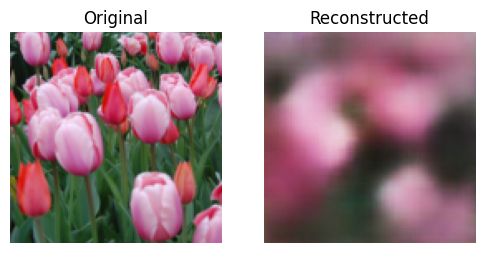

MSE:  0.020269088
SSIM:  0.37305352


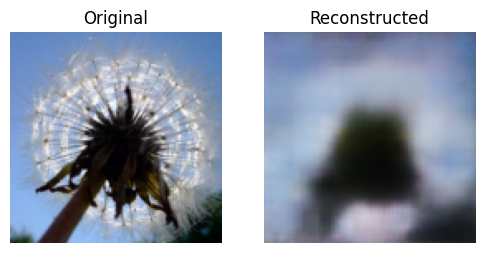

MSE:  0.027958615
SSIM:  0.14539097


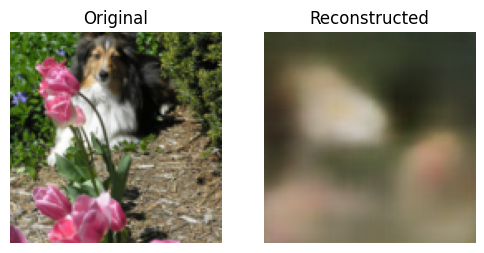

MSE:  0.014766533
SSIM:  0.13608368


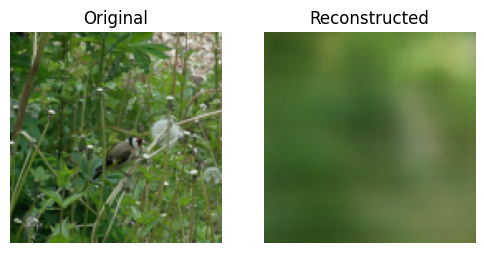

MSE:  0.020622468
SSIM:  0.24842668


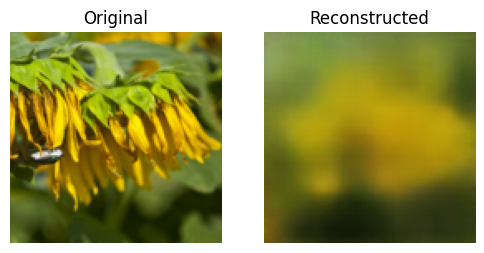

In [186]:
show_imgs(v[0], v[2])

In [158]:
def generate_images(model, flower="daisy", num_images=9):
    plt.figure(figsize=(9,9))
    plt.tight_layout()
    for i in range(num_images):
      plt.subplot(3, 3, i+1)
      plt.imshow(np.transpose(model.sample(1, flower_dict[flower]).cpu()[0], (1, 2, 0)))
      plt.axis('off')
      # Reconstructed
    plt.show()

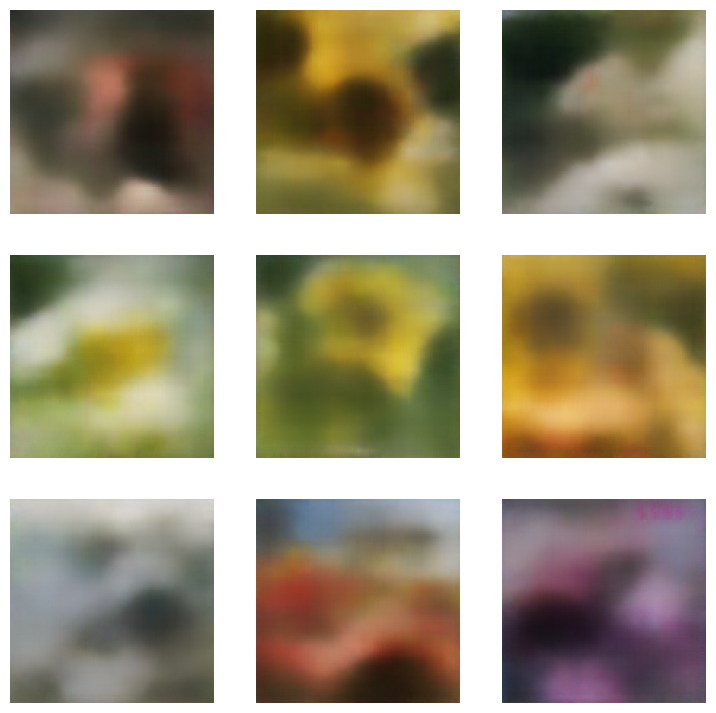

In [173]:
generate_images(model, "sunflowers")

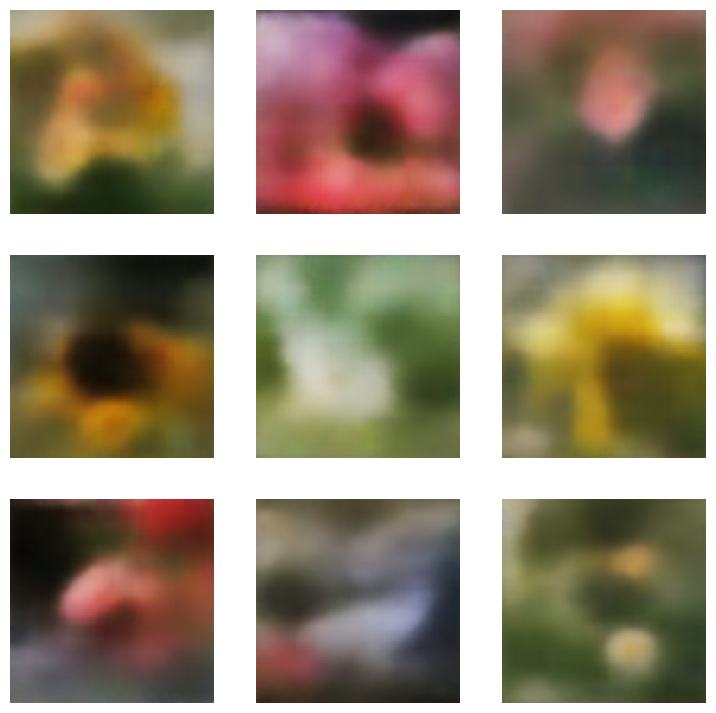

In [176]:
generate_images(model, "roses")